In [7]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from astar import AStar

In [8]:

def load_grid(path: Path):
    try:
        with open(path, 'r') as f:
            grid = np.loadtxt(f)
    except FileNotFoundError:
        print("The file doesn't exist, loading sample")
        grid = generate_sample_grid(10, 10)
    return grid


In [9]:

def generate_sample_grid(rows, cols):
    grid = np.random.random((rows, cols))
    grid[0, 0] = 1  # Start position
    grid[rows-1, cols-1] = 0  # Goal position
    # Generate obstacles
    for i in range(rows):
        for j in range(cols):
            if grid[i, j] != 1 and grid[i, j] != 0:
                grid[i, j] = np.random.choice([0, 1], p=[0.8, 0.2])
    return grid

In [10]:
class DronePlanning(AStar):
    def __init__(self, start, goal, grid):
        self.start = start
        self.goal = goal
        self.grid = grid
        self.cost_estimates = np.zeros_like(grid, dtype=float)

    def neighbors(self, node):
        x, y = node
        neighbors = [(x+1, y), (x-1, y), (x, y+1), (x, y-1)]
        return [n for n in neighbors if 0 <= n[0] < self.grid.shape[0] and 0 <= n[1] < self.grid.shape[1] and self.grid[n[0], n[1]] == 0]

    def distance_between(self, n1, n2):
        return 1

    def heuristic_cost_estimate(self, current, goal):
        x, y = current
        gx, gy = goal
        estimate = abs(gx - x) + abs(gy - y) + self.cost_estimates[x, y]
        self.cost_estimates[x, y] = estimate  # Store the cost estimate for visualization
        return estimate

    def is_goal_reached(self, current, goal):
        return current == goal

    def path_planning(self):
        path = list(self.astar(self.start, self.goal))
        return path


In [11]:

def path_planning(start, goal, grid: np.array):
    planner = DronePlanning(start, goal, grid)
    path = planner.path_planning()
    return path, planner.cost_estimates


In [12]:

def visualize_grid(grid, cost_estimates, path=None, title="Grid"):
    fig, ax = plt.subplots()
    ax.set_xticks(np.arange(grid.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(grid.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', size=0)
    ax.invert_yaxis()

    for (i, j), val in np.ndenumerate(grid):
        color = 'black' if val == 1 else 'white'
        ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color=color))
        if val != 1:  # Don't print values for obstacles
            ax.text(j, i, f'{cost_estimates[i, j]:.2f}', ha='center', va='center', color='white' if color == 'black' else 'black')
    
    if path:
        path = np.array(path)
        ax.plot(path[:, 1], path[:, 0], color='red')
    ax.scatter([start[1]], [start[0]], color='blue', label='Start')
    ax.scatter([goal[1]], [goal[0]], color='green', label='Goal')
    ax.set_title(title)
    ax.legend()
    plt.show(block=False)


In [13]:

def increase_utility_along_path(cost_estimates, path, increment):
    for node in path:
        if cost_estimates[node[0], node[1]] != 1:  # Don't increase utility for obstacles
            cost_estimates[node[0], node[1]] = min(cost_estimates[node[0], node[1]] + increment, 1.0)  # Cap the value at 1.0


The file doesn't exist, loading sample
Path 1: [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]


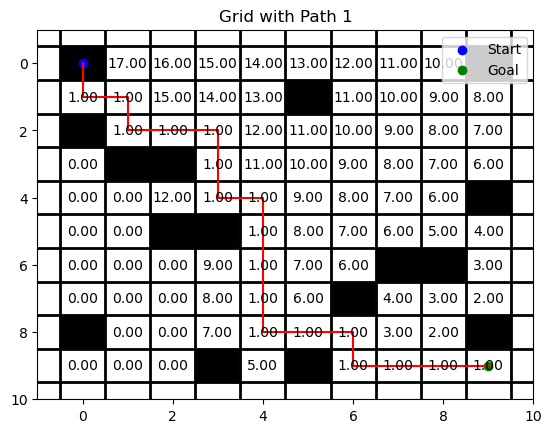

Path 2: [(0, 0), (1, 0), (1, 1), (2, 1), (2, 2), (2, 3), (3, 3), (4, 3), (4, 4), (5, 4), (6, 4), (7, 4), (8, 4), (8, 5), (8, 6), (9, 6), (9, 7), (9, 8), (9, 9)]


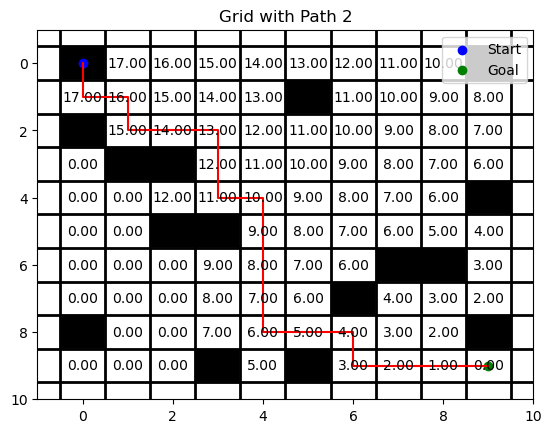

In [15]:


start = (0, 0)
goal = (9, 9)

cost_increment = 1.0  # Variable to control the increase in cost due to the first robot's path

grid_path = Path('grid.npy')
grid = load_grid(grid_path)

# First robot's path
path1, cost_estimates1 = path_planning(start, goal, grid)
if path1:
    print("Path 1:", path1)
    increase_utility_along_path(cost_estimates1, path1, increment=cost_increment)
else:
    print("No path found for the first robot")

# Visualize grid after first robot's path
visualize_grid(grid, cost_estimates1, path1, title="Grid with Path 1")

# Second robot's path
path2, cost_estimates2 = path_planning(start, goal, grid)
if path2:
    print("Path 2:", path2)
else:
    print("No path found for the second robot")

# Visualize grid after second robot's path
visualize_grid(grid, cost_estimates2, path2, title="Grid with Path 2")

